# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 462 kB 31.4 MB/s 
  Created wheel for adapt: filename=adapt-0.4.0-py3-none-any.whl size=101264 sha256=1905754c15f6ba64b49d4810043b7dd15ed61f769b9155ffbbd8aaac05d41221
  Stored in directory: /root/.cache/pip/wheels/47/47/61/e923985c37a7075ec75c4b16295782354b1c5dd291d47a7637
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
BATCH_SIZE = 8
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

125

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train1), "rb") as f:
    TCGA_cyclegan_train1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_train2), "rb") as f:
    TCGA_cyclegan_train2 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test1), "rb") as f:
    TCGA_cyclegan_test1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test2), "rb") as f:
    TCGA_cyclegan_test2 = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train1['train'] + TCGA_cyclegan_train2['train']
TCGA_cyclegan_train_labels = np.concatenate((TCGA_cyclegan_train1['train_label'],TCGA_cyclegan_train2['train_label']))
TCGA_cyclegan_test_data = TCGA_cyclegan_test1['test'] + TCGA_cyclegan_test2['test']
TCGA_cyclegan_test_labels = np.concatenate((TCGA_cyclegan_test1['test_label'],TCGA_cyclegan_test2['test_label']))

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_train_labels:  (3200,)
The shape of TCGA_cyclegan_test_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_test_labels:  (3200,)


In [ ]:
import gc
gc.collect()

250

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


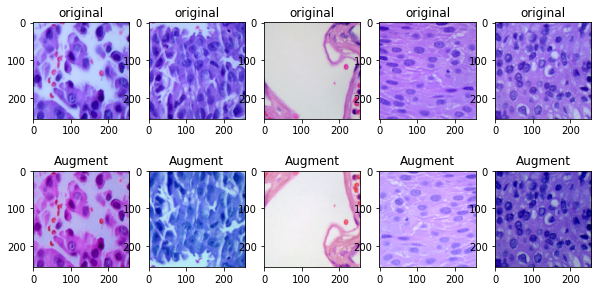

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

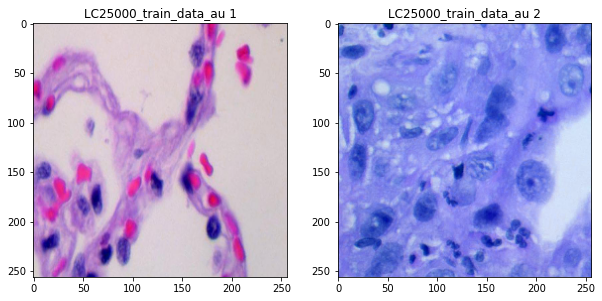

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data_au 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data_au 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

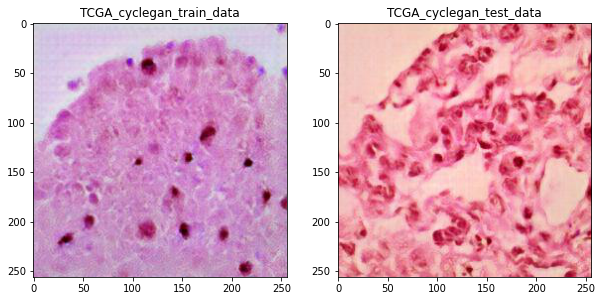

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_256.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 512)]     0         
                                                                 
 block5_conv1 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 8, 8, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_cyclegan_train_lab = one.transform(np.array(TCGA_cyclegan_train_labels).reshape(-1, 1))

print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data_au (source) shape: (3200, 256, 256, 3)
TCGA_cyclegan_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 4s 71ms/step - loss: 2.1503 - acc: 0.6119 - val_loss: 1.7102 - val_acc: 0.3378
Epoch 2/5
50/50 [==============================] - 3s 52ms/step - loss: 0.8715 - acc: 0.7650 - val_loss: 1.5281 - val_acc: 0.4169
Epoch 3/5
50/50 [==============================] - 3s 51ms/step - loss: 0.6280 - acc: 0.8125 - val_loss: 1.7036 - val_acc: 0.4097
Epoch 4/5
50/50 [==============================] - 3s 52ms/step - loss: 0.4769 - acc: 0.8500 - val_loss: 1.6181 - val_acc: 0.4216
Epoch 5/5
50/50 [==============================] - 3s 52ms/step - loss: 0.4494 - acc: 0.8462 - val_loss: 1.9383 - val_acc: 0.3837
Epoch 1/100
50/50 [==============================] - 5s 88ms/step - loss: 0.4484 - acc: 0.8628 - val_loss: 1.7160 - val_acc: 0.3806
Epoch 2/100
50/50 [==============================] - 3s 68ms/step - loss: 0.3468 - acc: 0.8781 - val_loss: 1.6027 - val_acc: 0.3884
Epoch 3/100
50/50 [==============================] - 3s 68ms/step - loss: 0.3328 - acc

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 6s 66ms/step - loss: 2.1197 - acc: 0.6200 - val_loss: 2.9014 - val_acc: 0.3250
Epoch 2/5
50/50 [==============================] - 2s 49ms/step - loss: 1.1333 - acc: 0.7225 - val_loss: 1.8722 - val_acc: 0.3966
Epoch 3/5
50/50 [==============================] - 2s 49ms/step - loss: 0.6943 - acc: 0.7994 - val_loss: 1.6783 - val_acc: 0.4144
Epoch 4/5
50/50 [==============================] - 2s 48ms/step - loss: 0.5241 - acc: 0.8213 - val_loss: 1.7452 - val_acc: 0.4225
Epoch 5/5
50/50 [==============================] - 2s 48ms/step - loss: 0.4914 - acc: 0.8306 - val_loss: 1.6442 - val_acc: 0.4216
Epoch 1/100
50/50 [==============================] - 7s 81ms/step - loss: 0.3796 - acc: 0.8737 - val_loss: 1.7279 - val_acc: 0.3884
Epoch 2/100
50/50 [==============================] - 3s 66ms/step - loss: 0.3321 - acc: 0.8847 - val_loss: 1.5419 - val_acc: 0.4100
Epoch 3/100
50/50 [==============================] - 3s 65ms/step - loss: 0.3135 - acc

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
50/50 [==============================] - 4s 80ms/step - loss: 2.4435e-06 - acc: 1.0000 - val_loss: 10.7340 - val_acc: 0.3747
Epoch 2/100
50/50 [==============================] - 3s 67ms/step - loss: 1.4646e-05 - acc: 1.0000 - val_loss: 10.7004 - val_acc: 0.3753
Epoch 3/100
50/50 [==============================] - 3s 66ms/step - loss: 1.2143e-05 - acc: 1.0000 - val_loss: 10.8131 - val_acc: 0.3713
Epoch 4/100
50/50 [==============================] - 3s 65ms/step - loss: 4.7100e-06 - acc: 1.0000 - val_loss: 10.9148 - val_acc: 0.3709
Epoch 5/100
50/50 [==============================] - 3s 65ms/step - loss: 4.7489e-06 - acc: 1.0000 - val_loss: 10.8583 - val_acc: 0.3744
Epoch 6/100
50/50 [==============================] - 3s 65ms/step - loss: 3.6219e-06 - acc: 1.0000 - val_loss: 10.8875 - val_acc: 0.3744
Epoch 7/100
50/50 [==============================] - 3s 65ms/step - loss: 2.7306e-06 - acc: 1.0000 - val_loss: 10.8632 - val_acc: 0.3753
Epoch 8/100
50/50 [======================

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 4s 63ms/step - loss: 2.0072 - acc: 0.6209 - val_loss: 1.8290 - val_acc: 0.3069
Epoch 2/5
50/50 [==============================] - 2s 48ms/step - loss: 0.8358 - acc: 0.7788 - val_loss: 1.5240 - val_acc: 0.4047
Epoch 3/5
50/50 [==============================] - 2s 49ms/step - loss: 0.5287 - acc: 0.8431 - val_loss: 1.8977 - val_acc: 0.3834
Epoch 4/5
50/50 [==============================] - 2s 48ms/step - loss: 0.4844 - acc: 0.8472 - val_loss: 1.8631 - val_acc: 0.3981
Epoch 5/5
50/50 [==============================] - 2s 49ms/step - loss: 0.4324 - acc: 0.8462 - val_loss: 2.0253 - val_acc: 0.3731
Epoch 1/100
50/50 [==============================] - 5s 80ms/step - loss: 0.4231 - acc: 0.8628 - val_loss: 2.0933 - val_acc: 0.3625
Epoch 2/100
50/50 [==============================] - 3s 65ms/step - loss: 0.3979 - acc: 0.8575 - val_loss: 2.0172 - val_acc: 0.3591
Epoch 3/100
50/50 [==============================] - 3s 64ms/step - loss: 0.3415 - acc

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 4s 64ms/step - loss: 1.7250 - acc: 0.6566 - val_loss: 2.0014 - val_acc: 0.2528
Epoch 2/5
50/50 [==============================] - 2s 48ms/step - loss: 0.7393 - acc: 0.7903 - val_loss: 1.6860 - val_acc: 0.3625
Epoch 3/5
50/50 [==============================] - 2s 49ms/step - loss: 0.5390 - acc: 0.8497 - val_loss: 1.8819 - val_acc: 0.3812
Epoch 4/5
50/50 [==============================] - 2s 49ms/step - loss: 0.4512 - acc: 0.8597 - val_loss: 1.9716 - val_acc: 0.3837
Epoch 5/5
50/50 [==============================] - 2s 48ms/step - loss: 0.4327 - acc: 0.8497 - val_loss: 1.9905 - val_acc: 0.3869
Epoch 1/100
50/50 [==============================] - 5s 81ms/step - loss: 0.4375 - acc: 0.8637 - val_loss: 1.7947 - val_acc: 0.3806
Epoch 2/100
50/50 [==============================] - 3s 65ms/step - loss: 0.3565 - acc: 0.8675 - val_loss: 1.7876 - val_acc: 0.3831
Epoch 3/100
50/50 [==============================] - 3s 66ms/step - loss: 0.3243 - acc

### Result

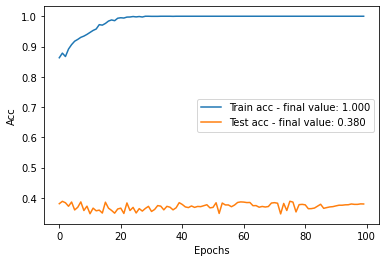

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


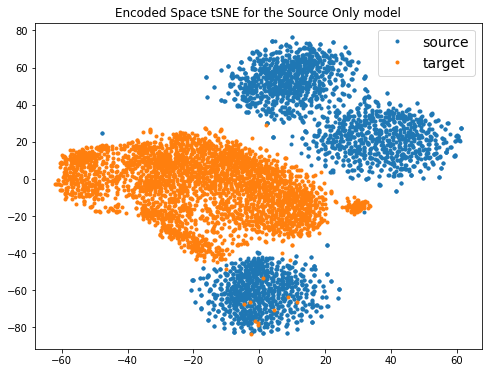

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.034046,0.987544,7.815826,0.371166
std,0.084131,0.030425,2.762143,0.010556
min,0.000003,0.862813,1.602713,0.346875
25%,0.000011,0.997734,6.521533,0.365234
50%,0.000088,1.000000,9.323963,0.371875
75%,0.004656,1.000000,9.810009,0.378516
max,0.448431,1.000000,10.345664,0.388750


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_VGG_256_ARMS_0.5e-5_AU_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 14s 28ms/step - loss: 0.5814 - acc: 0.8344 - disc_loss: 3.6544 - val_loss: 2.5318 - val_acc: 0.4019
Epoch 2/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1855 - acc: 0.9350 - disc_loss: 2.5047 - val_loss: 4.2072 - val_acc: 0.3847
Epoch 3/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1835 - acc: 0.9447 - disc_loss: 2.7705 - val_loss: 4.4311 - val_acc: 0.4247
Epoch 4/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1963 - acc: 0.9450 - disc_loss: 3.5905 - val_loss: 6.0913 - val_acc: 0.4578
Epoch 5/100
400/400 [==============================] - 10s 26ms/step - loss: 0.2182 - acc: 0.9488 - disc_loss: 5.3103 - val_loss: 5.8094 - val_acc: 0.4266
Epoch 6/100
400/400 [==============================] - 10s 26ms/step - loss: 0.2630 - acc: 0.9403 - disc_loss: 6.7958 - val_loss: 7.1892 - val_acc: 0.4456
Epoch 7/100
400/400 [==============================] - 10s 26ms/step -

### Run 2

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 18s 30ms/step - loss: 0.5635 - acc: 0.8425 - disc_loss: 3.4577 - val_loss: 2.5347 - val_acc: 0.4038
Epoch 2/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1956 - acc: 0.9394 - disc_loss: 2.5181 - val_loss: 3.6481 - val_acc: 0.4419
Epoch 3/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1891 - acc: 0.9459 - disc_loss: 2.7941 - val_loss: 4.9247 - val_acc: 0.4684
Epoch 4/100
400/400 [==============================] - 11s 28ms/step - loss: 0.2464 - acc: 0.9369 - disc_loss: 4.0382 - val_loss: 6.0868 - val_acc: 0.4569
Epoch 5/100
400/400 [==============================] - 11s 28ms/step - loss: 0.2399 - acc: 0.9381 - disc_loss: 5.3781 - val_loss: 6.1804 - val_acc: 0.4666
Epoch 6/100
400/400 [==============================] - 11s 28ms/step - loss: 0.3220 - acc: 0.9347 - disc_loss: 7.2457 - val_loss: 7.1756 - val_acc: 0.4800
Epoch 7/100
400/400 [==============================] - 11s 28ms/step -

### Run 3

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 14s 29ms/step - loss: 0.0789 - acc: 0.9869 - disc_loss: 14.1631 - val_loss: 34.0342 - val_acc: 0.5050
Epoch 2/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1573 - acc: 0.9816 - disc_loss: 16.7343 - val_loss: 36.3761 - val_acc: 0.4925
Epoch 3/100
400/400 [==============================] - 11s 28ms/step - loss: 0.2431 - acc: 0.9653 - disc_loss: 30.8572 - val_loss: 23.5882 - val_acc: 0.4944
Epoch 4/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1904 - acc: 0.9719 - disc_loss: 31.0383 - val_loss: 14.3127 - val_acc: 0.4872
Epoch 5/100
400/400 [==============================] - 11s 28ms/step - loss: 0.2210 - acc: 0.9678 - disc_loss: 30.2755 - val_loss: 12.7435 - val_acc: 0.4925
Epoch 6/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1538 - acc: 0.9684 - disc_loss: 28.5763 - val_loss: 19.9815 - val_acc: 0.4916
Epoch 7/100
400/400 [==============================] - 11s

### Run 4

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 15s 30ms/step - loss: 0.0401 - acc: 0.9953 - disc_loss: 15.2883 - val_loss: 48.1090 - val_acc: 0.4644
Epoch 2/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1584 - acc: 0.9828 - disc_loss: 26.7895 - val_loss: 40.5891 - val_acc: 0.4888
Epoch 3/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1419 - acc: 0.9816 - disc_loss: 31.2357 - val_loss: 31.4503 - val_acc: 0.4931
Epoch 4/100
400/400 [==============================] - 11s 28ms/step - loss: 0.0844 - acc: 0.9859 - disc_loss: 31.3160 - val_loss: 30.6941 - val_acc: 0.4938
Epoch 5/100
400/400 [==============================] - 11s 28ms/step - loss: 0.0470 - acc: 0.9900 - disc_loss: 31.5886 - val_loss: 26.5872 - val_acc: 0.4731
Epoch 6/100
400/400 [==============================] - 11s 28ms/step - loss: 0.0651 - acc: 0.9897 - disc_loss: 31.6872 - val_loss: 31.1874 - val_acc: 0.4834
Epoch 7/100
400/400 [==============================] - 11s

### Run 5

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 15s 30ms/step - loss: 0.0133 - acc: 0.9984 - disc_loss: 15.7494 - val_loss: 91.8523 - val_acc: 0.4972
Epoch 2/100
400/400 [==============================] - 11s 28ms/step - loss: 0.0789 - acc: 0.9928 - disc_loss: 15.7707 - val_loss: 83.9265 - val_acc: 0.4834
Epoch 3/100
400/400 [==============================] - 11s 28ms/step - loss: 0.0506 - acc: 0.9941 - disc_loss: 15.6923 - val_loss: 88.1038 - val_acc: 0.4959
Epoch 4/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1578 - acc: 0.9769 - disc_loss: 29.4149 - val_loss: 99.6885 - val_acc: 0.4991
Epoch 5/100
400/400 [==============================] - 11s 28ms/step - loss: 0.0939 - acc: 0.9837 - disc_loss: 37.5706 - val_loss: 117.6557 - val_acc: 0.4994
Epoch 6/100
400/400 [==============================] - 11s 28ms/step - loss: 0.0860 - acc: 0.9831 - disc_loss: 37.8458 - val_loss: 132.4895 - val_acc: 0.4994
Epoch 7/100
400/400 [==============================] - 1

### Result

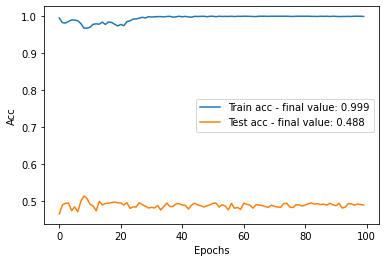

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


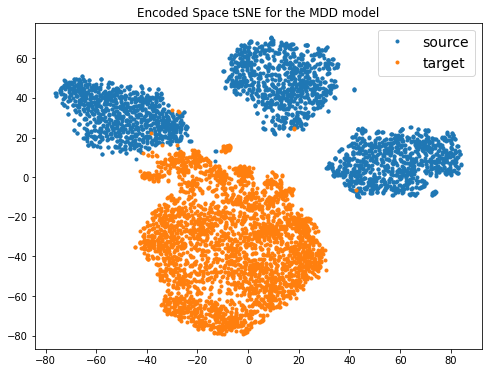

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,2.878713e-02,0.994784,25.191095,55.124950,0.487700
std,4.825155e-02,0.008621,5.028451,18.348693,0.006944
min,3.488107e-07,0.967500,11.956789,13.643247,0.464375
25%,2.040930e-04,0.994219,21.422582,37.725204,0.483359
50%,2.733874e-03,0.999375,23.913578,62.276114,0.488438
75%,4.017801e-02,1.000000,27.899174,68.048210,0.492266
max,1.717318e-01,1.000000,33.877190,84.436256,0.512812


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_VGG_256_RMS_0.5e-5_g1_AU_cyclegan.csv")

In [ ]:
import gc
gc.collect()

4091